## Denoiser

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import mlflow

Using TensorFlow backend.


In [3]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

# logging.basicConfig(level=logging.DEBUG)

In [6]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

mlflow.set_tracking_uri(str(Path(path_to_data, 'mlruns')))

In [21]:
import glob
import yaml

path_to_mlflow = '/home/Edu/data/mlruns'
meta = glob.glob(str(Path(path_to_mlflow, '**/meta.yaml')))

def load_yaml(path):
    with open(path) as f:
        content = yaml.load(f)
    return content

experiments = [load_yaml(p) for p in meta]

def get_id_for_experiment_with_name(name):
    matches = [e['experiment_id'] for e in experiments if e['name'] == name]
    if len(matches):
        return matches[0]
    else:
        return mlflow.create_experiment(name)

experiment_name = 'denoiser'

In [35]:
print('Running YASS version: {}\nExperiment: {}'
      .format(yass_util.get_version(), experiment_name))

Running YASS version: 01bd23e min shift param is now passed through collided params
Experiment: denoiser


In [24]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')

CONFIG = read_config()

## Load training set

In [43]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.list_experiments() 
experiment = client.get_experiment_by_name('denoiser-training-set')
training_set_runs = client.list_run_infos(experiment.experiment_id)

In [46]:
path_to_training_set = Path(training_set_runs[0].artifact_uri, '2018-09-26T20-01-00.npz')

In [47]:
dataset = np.load(path_to_training_set)

In [49]:
x_train_noisy = dataset['x_train_noisy']
x_train_noisy = dataset['x_train_clean']
x_train_noisy = dataset['x_test_noisy']
x_train_noisy = dataset['x_test_clean']

MemoryError: 

## PCA

In [12]:
x_train_noisy.shape

(73920, 61, 49)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(0.50).fit(x_train_noisy.reshape((len(x_train_noisy), -1)))
pca.n_components_

203

In [14]:
components = pca.transform(x_test_noisy.reshape((len(x_test_noisy), -1)))
x_test_denoised_pca = pca.inverse_transform(components).reshape(x_test_noisy.shape)

In [15]:
residual_pca = x_test_denoised_pca - x_test_clean

In [16]:
np.mean(residual_pca ** 2)

0.6238296839425063

In [17]:
# worst we can do...
np.mean((x_test_clean - x_test_noisy) ** 2)

1.1038637534325544

In [140]:
selected = np.random.randint(x_test_noisy.shape[0], size=10)

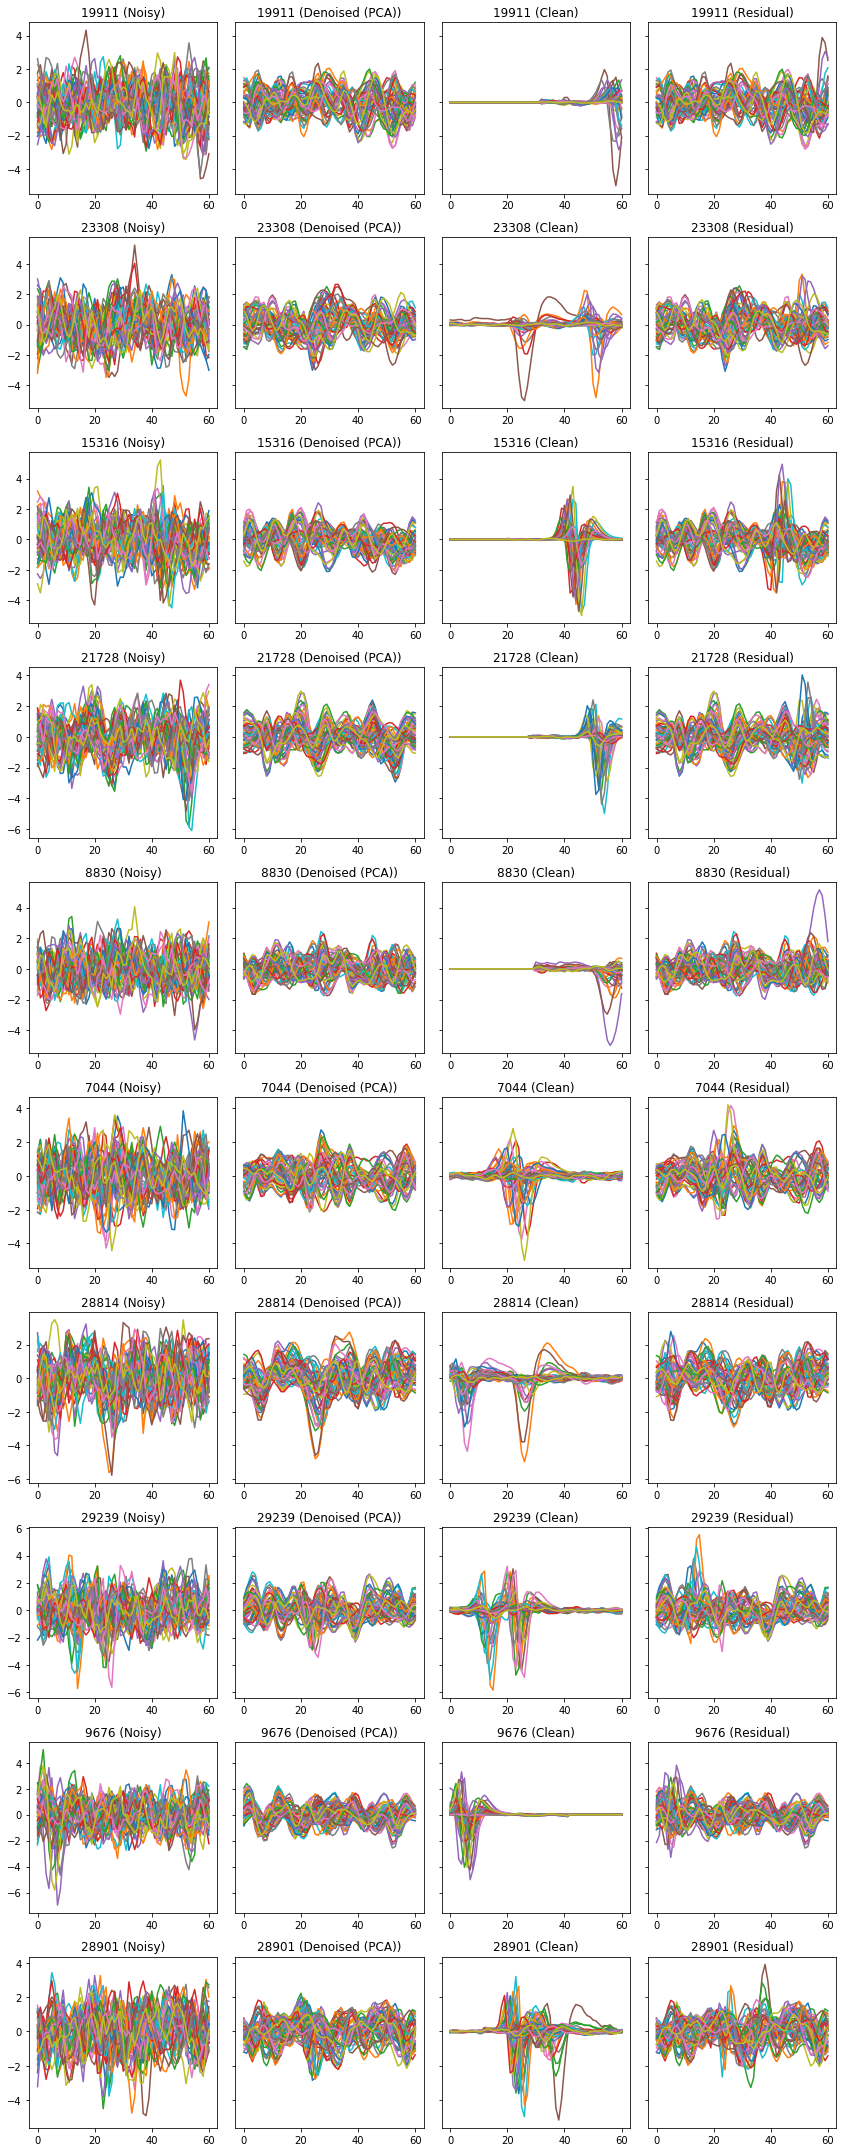

In [19]:
plot.grid_from_array([x_test_noisy,
                      x_test_denoised_pca,
                      x_test_clean,
                     residual_pca],
                     axis=0,
                     group_names=('Noisy', 'Denoised (PCA)', 'Clean', 'Residual'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

In [20]:
n_spikes, waveform_length, n_neighbors = x_train_clean.shape

# Network parameters
input_shape = (waveform_length, n_neighbors, 1)
batch_size = 512
kernel_size = 3
latent_dim = 32

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=1,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=1,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)


outputs = Activation('linear', name='decoder_output')(x)

# outputs = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 61, 49, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 49, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 49, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 191296)            0         
_________________________________________________________________
latent_vector (Dense)        (None, 32)                6121504   
Total params: 6,140,320
Trainable params: 6,140,320
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


## Training

In [123]:
# Train or loadthe autoencoder
# model_to_load = '25-Jul-2018@23-49-01.h5'
model_to_load = None

# Training parameters
epochs = 1
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.05, patience=2)]
callbacks = []

if model_to_load:
    autoencoder = load_model(model_to_load)
    print('Loaded {}'.format(model_to_load))
else:
    with mlflow.start_run(experiment_id=EXPERIMENT_ID):
        history = autoencoder.fit(x_train_noisy[:, :, :, np.newaxis],
                                  x_train_clean[:, :, :, np.newaxis],
                                  validation_data=(x_test_noisy[:, :, :, np.newaxis],
                                                   x_test_clean[:, :, :, np.newaxis]),
                                  epochs=epochs,
                                  callbacks=callbacks,
                                  batch_size=batch_size)
        name = reproducibility.make_filename(extension='h5')
        path = str(Path(path_to_data, 'denoiser', 'models', name))
        autoencoder.save(path)
        print('Saved {}'.format(name))
        
        mlflow.log_param('epoch', history.epoch)
        mlflow.log_param('history', history.history)
        mlflow.log_param('name', name)
        mlflow.log_param('kernel_size', kernel_size)
        mlflow.log_param('latent_dim', latent_dim)
        
        for name, value in history.params.items():
            mlflow.log_param(name, value)
        
        mlflow.log_param('epoch_last', history.epoch[-1])
        
        last_history = {name: value[-1] for name, value in history.history.items()}
        
        for name, value in last_history.items():
            mlflow.log_metric(name+'_last', value)

Notice: failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: [Errno 12] Cannot allocate memory


Train on 73920 samples, validate on 31680 samples
Epoch 1/1
73920/73920 [==============================] - 103s 1ms/step - loss: 0.0435 - val_loss: 0.0525
Saved 2018-09-26T16-34-48.h5


best val_loss: 0.0551, 2018-09-26T16-06-20:h5

## Denoising (simulated) patches


In [22]:
def predict(model, x):
    x = x[:, :, :, np.newaxis]
    predictions = model.predict(x)
    return np.squeeze(predictions)

In [23]:
x_test_denoised = predict(autoencoder, np.squeeze(x_test_noisy))

In [24]:
residual = x_test_denoised - x_test_clean

In [25]:
np.mean(residual ** 2)

0.055114361796635945

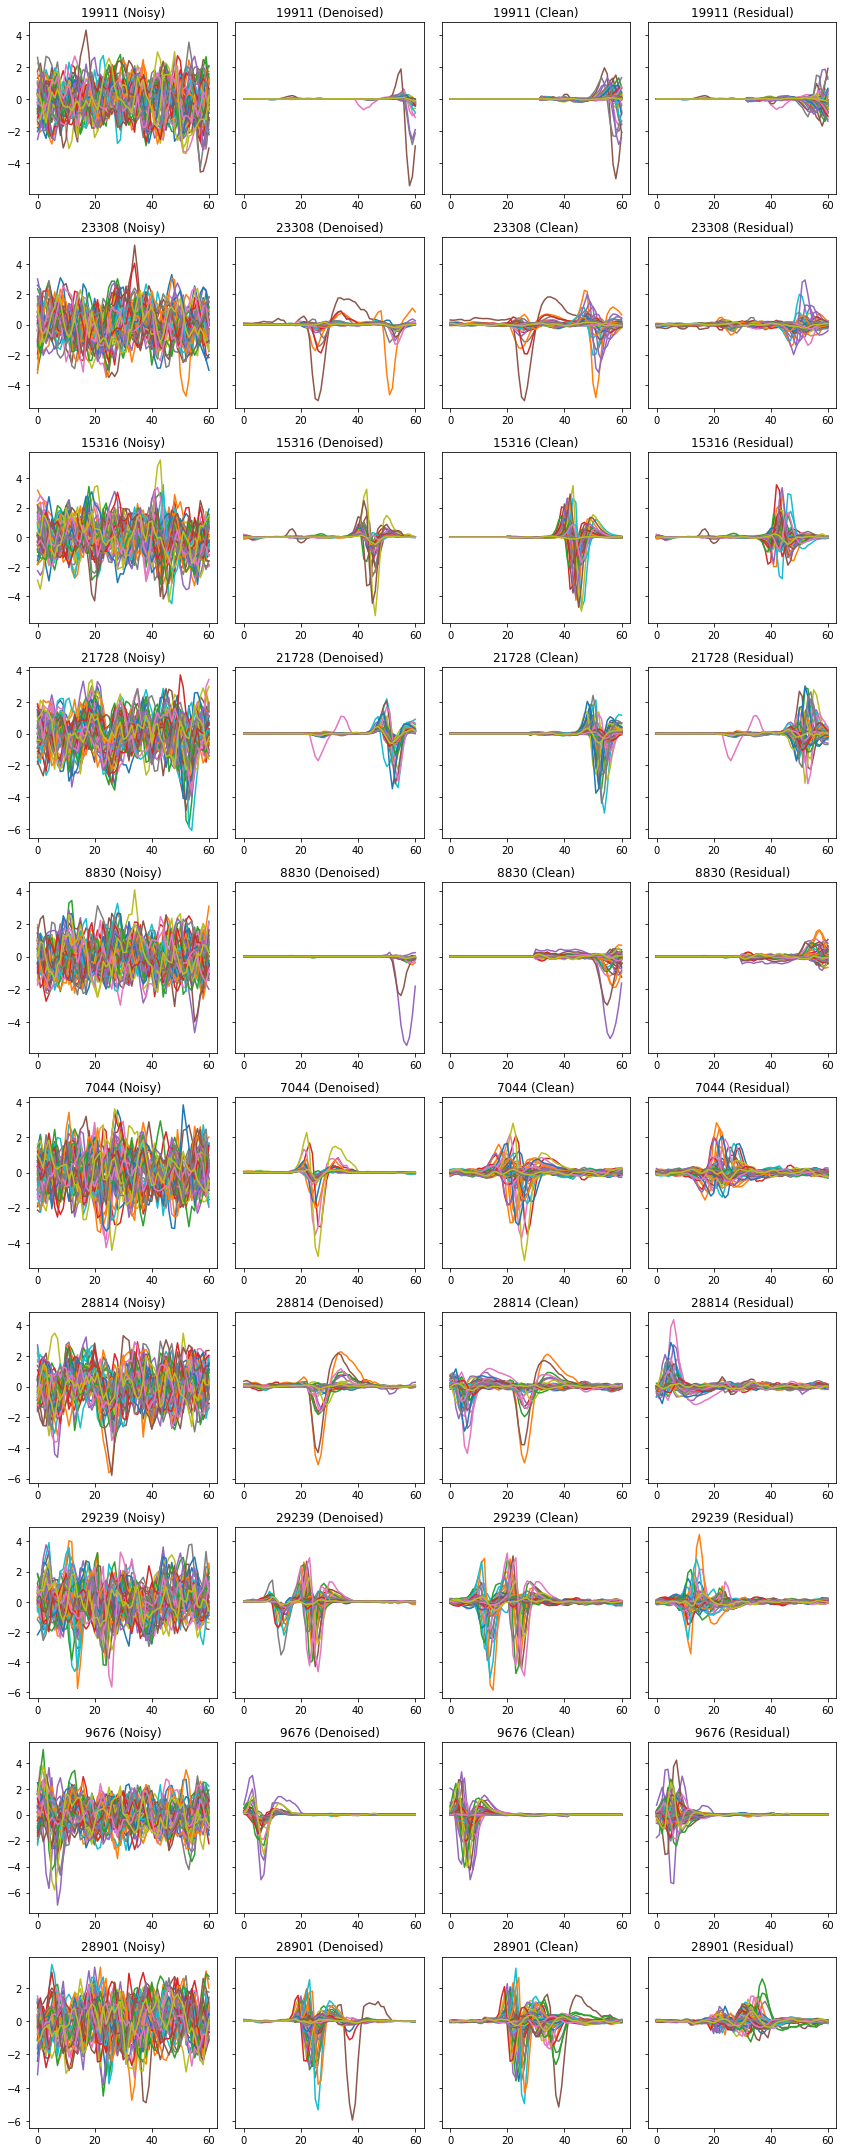

In [27]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      np.squeeze(x_test_clean),
                      residual],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Clean', 'Residual'),
                     elements=selected,
                     auto_figsize=3,
                     sharey='row')

In [151]:
selected

array([ 3067, 27767, 11905, 18898, 19705,  2112, 14660, 16463, 25869,
       10627])

DEBUG:dstools.plot.plot:Rows: 6, Cols: 6
DEBUG:dstools.plot.plot:Plotting in 0, 0
DEBUG:dstools.plot.plot:Plotting in 0, 1
DEBUG:dstools.plot.plot:Plotting in 0, 2
DEBUG:dstools.plot.plot:Plotting in 0, 3
DEBUG:dstools.plot.plot:Plotting in 0, 4
DEBUG:dstools.plot.plot:Plotting in 0, 5
DEBUG:dstools.plot.plot:Plotting in 1, 0
DEBUG:dstools.plot.plot:Plotting in 1, 1
DEBUG:dstools.plot.plot:Plotting in 1, 2
DEBUG:dstools.plot.plot:Plotting in 1, 3
DEBUG:dstools.plot.plot:Plotting in 1, 4
DEBUG:dstools.plot.plot:Plotting in 1, 5
DEBUG:dstools.plot.plot:Plotting in 2, 0
DEBUG:dstools.plot.plot:Plotting in 2, 1
DEBUG:dstools.plot.plot:Plotting in 2, 2
DEBUG:dstools.plot.plot:Plotting in 2, 3
DEBUG:dstools.plot.plot:Plotting in 2, 4
DEBUG:dstools.plot.plot:Plotting in 2, 5
DEBUG:dstools.plot.plot:Plotting in 3, 0
DEBUG:dstools.plot.plot:Plotting in 3, 1
DEBUG:dstools.plot.plot:Plotting in 3, 2
DEBUG:dstools.plot.plot:Plotting in 3, 3
DEBUG:dstools.plot.plot:Plotting in 3, 4
DEBUG:dstools.pl

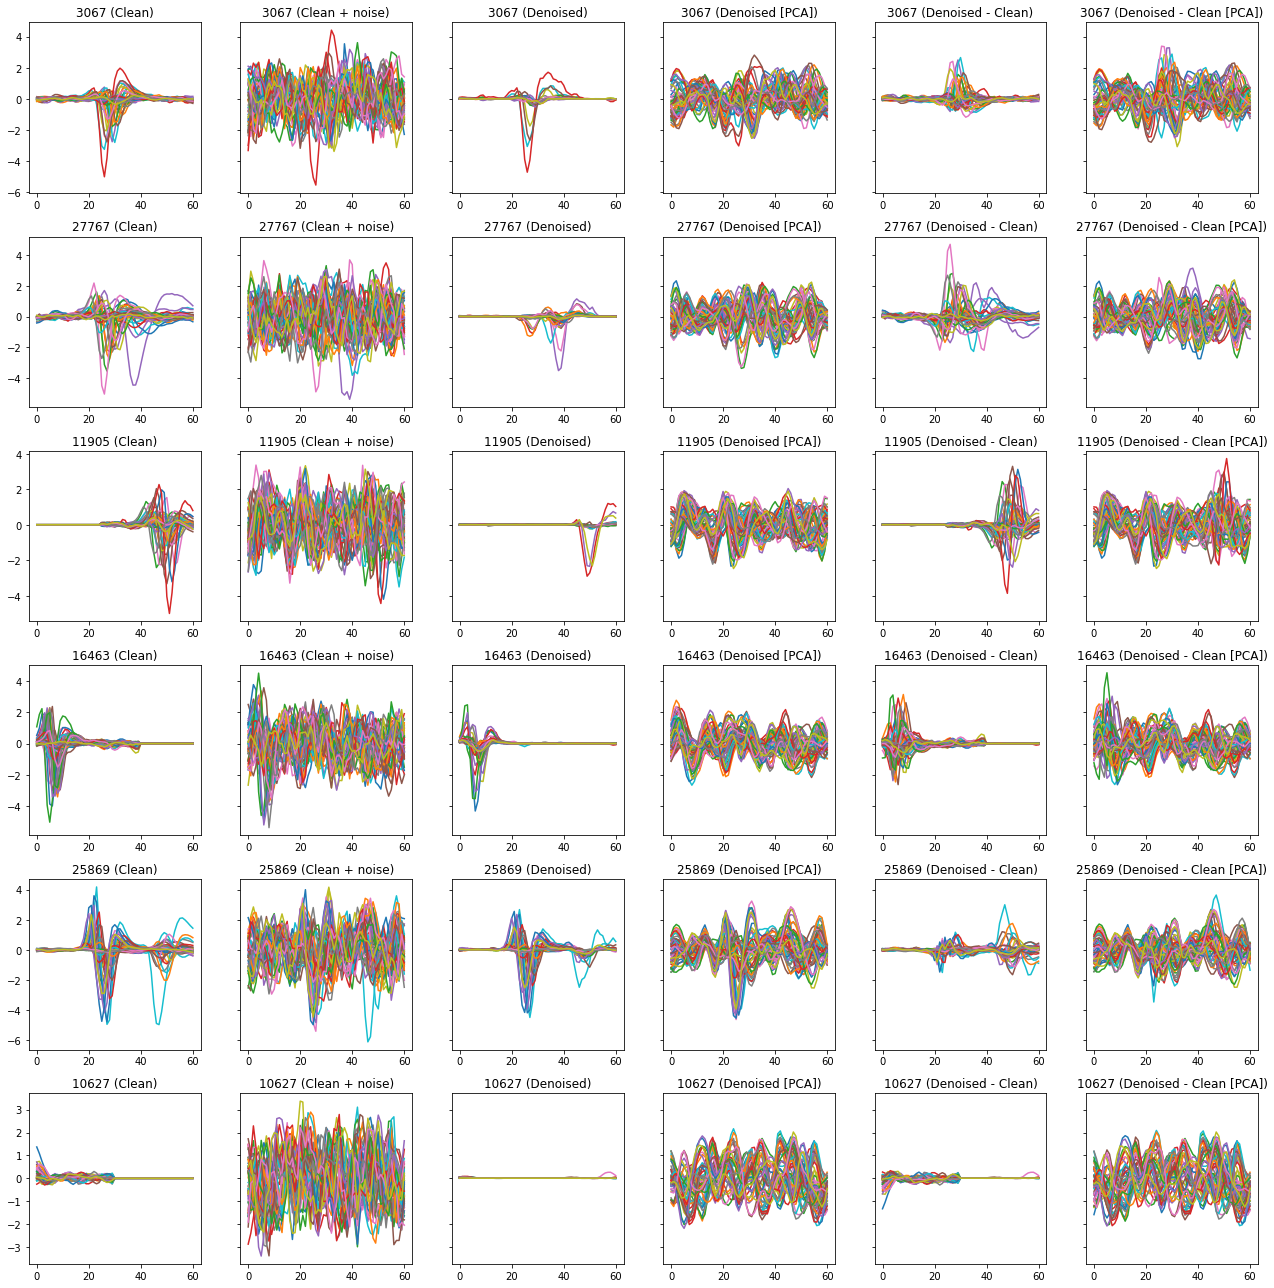

In [163]:
arrs = [np.squeeze(x_test_clean), np.squeeze(x_test_noisy),
       x_test_denoised, x_test_denoised_pca,
       residual, residual_pca]

groups = ['Clean', 'Clean + noise', 'Denoised', 'Denoised [PCA]', 'Denoised - Clean', 'Denoised - Clean [PCA]']

plot.grid_from_array(arrs,
                     axis=0,
                     group_names=groups,
                     elements=selected[[0, 1, 2, 7, 8, 9]],
                     auto_figsize=3,
                     sharey='row')

savefig = True

if savefig:
    filename = reproducibility.make_filename(extension='png')
    plt.savefig(Path(path_to_data, 'denoiser', 'figs', filename))

## Best/worst denoised

In [29]:
errors = np.square(residual ** 2).sum(axis=(1, 2))

In [30]:
errors_sorted_idx = np.argsort(errors)

In [31]:
errors[errors_sorted_idx[:10]]

array([1.06715150e-05, 1.29639256e-05, 1.32180249e-05, 1.99935792e-05,
       2.20525437e-05, 2.62517437e-05, 2.82633991e-05, 3.09773746e-05,
       3.25968328e-05, 3.29741046e-05])

In [32]:
errors[errors_sorted_idx[-10:]]

array([ 9507.83880056,  9580.36894077,  9695.12238372, 10585.90224131,
       10740.634616  , 11160.19514008, 13437.11440953, 13686.22009639,
       15022.2252428 , 34054.58485328])

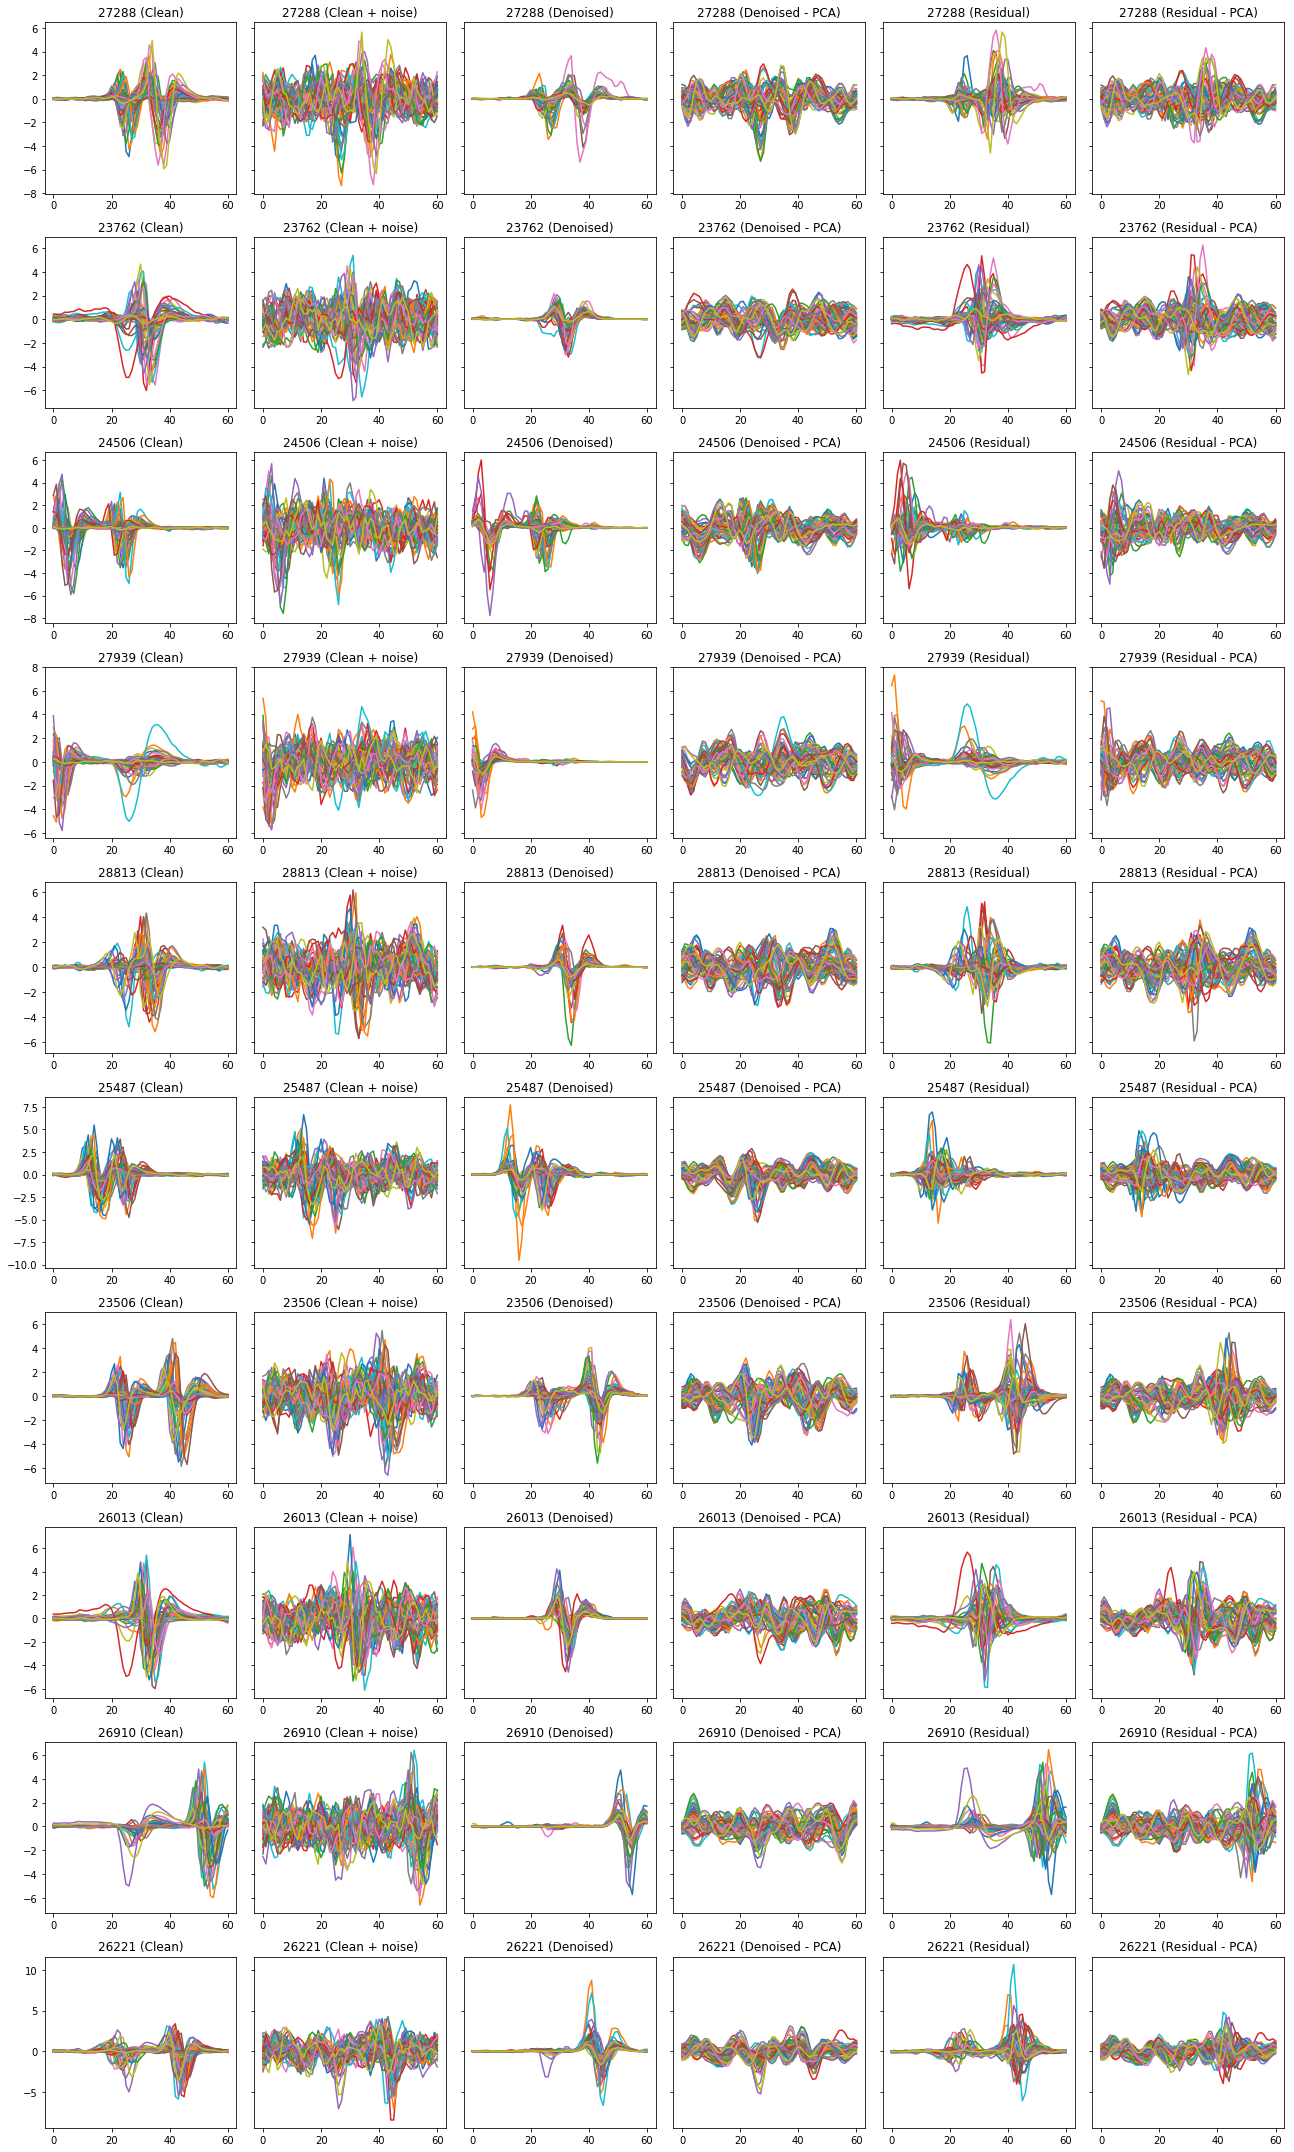

In [132]:
plot.grid_from_array([np.squeeze(x_test_clean),
                      np.squeeze(x_test_noisy),
                      x_test_denoised,
                      x_test_denoised_pca,
                      residual,
                      residual_pca],
                     axis=0,
                     group_names=('Clean', 'Clean + noise', 'Denoised', 'Denoised - PCA', 'Residual', 'Residual - PCA'),
                     elements=errors_sorted_idx[-10:],
                     auto_figsize=3,
                     sharey='row')

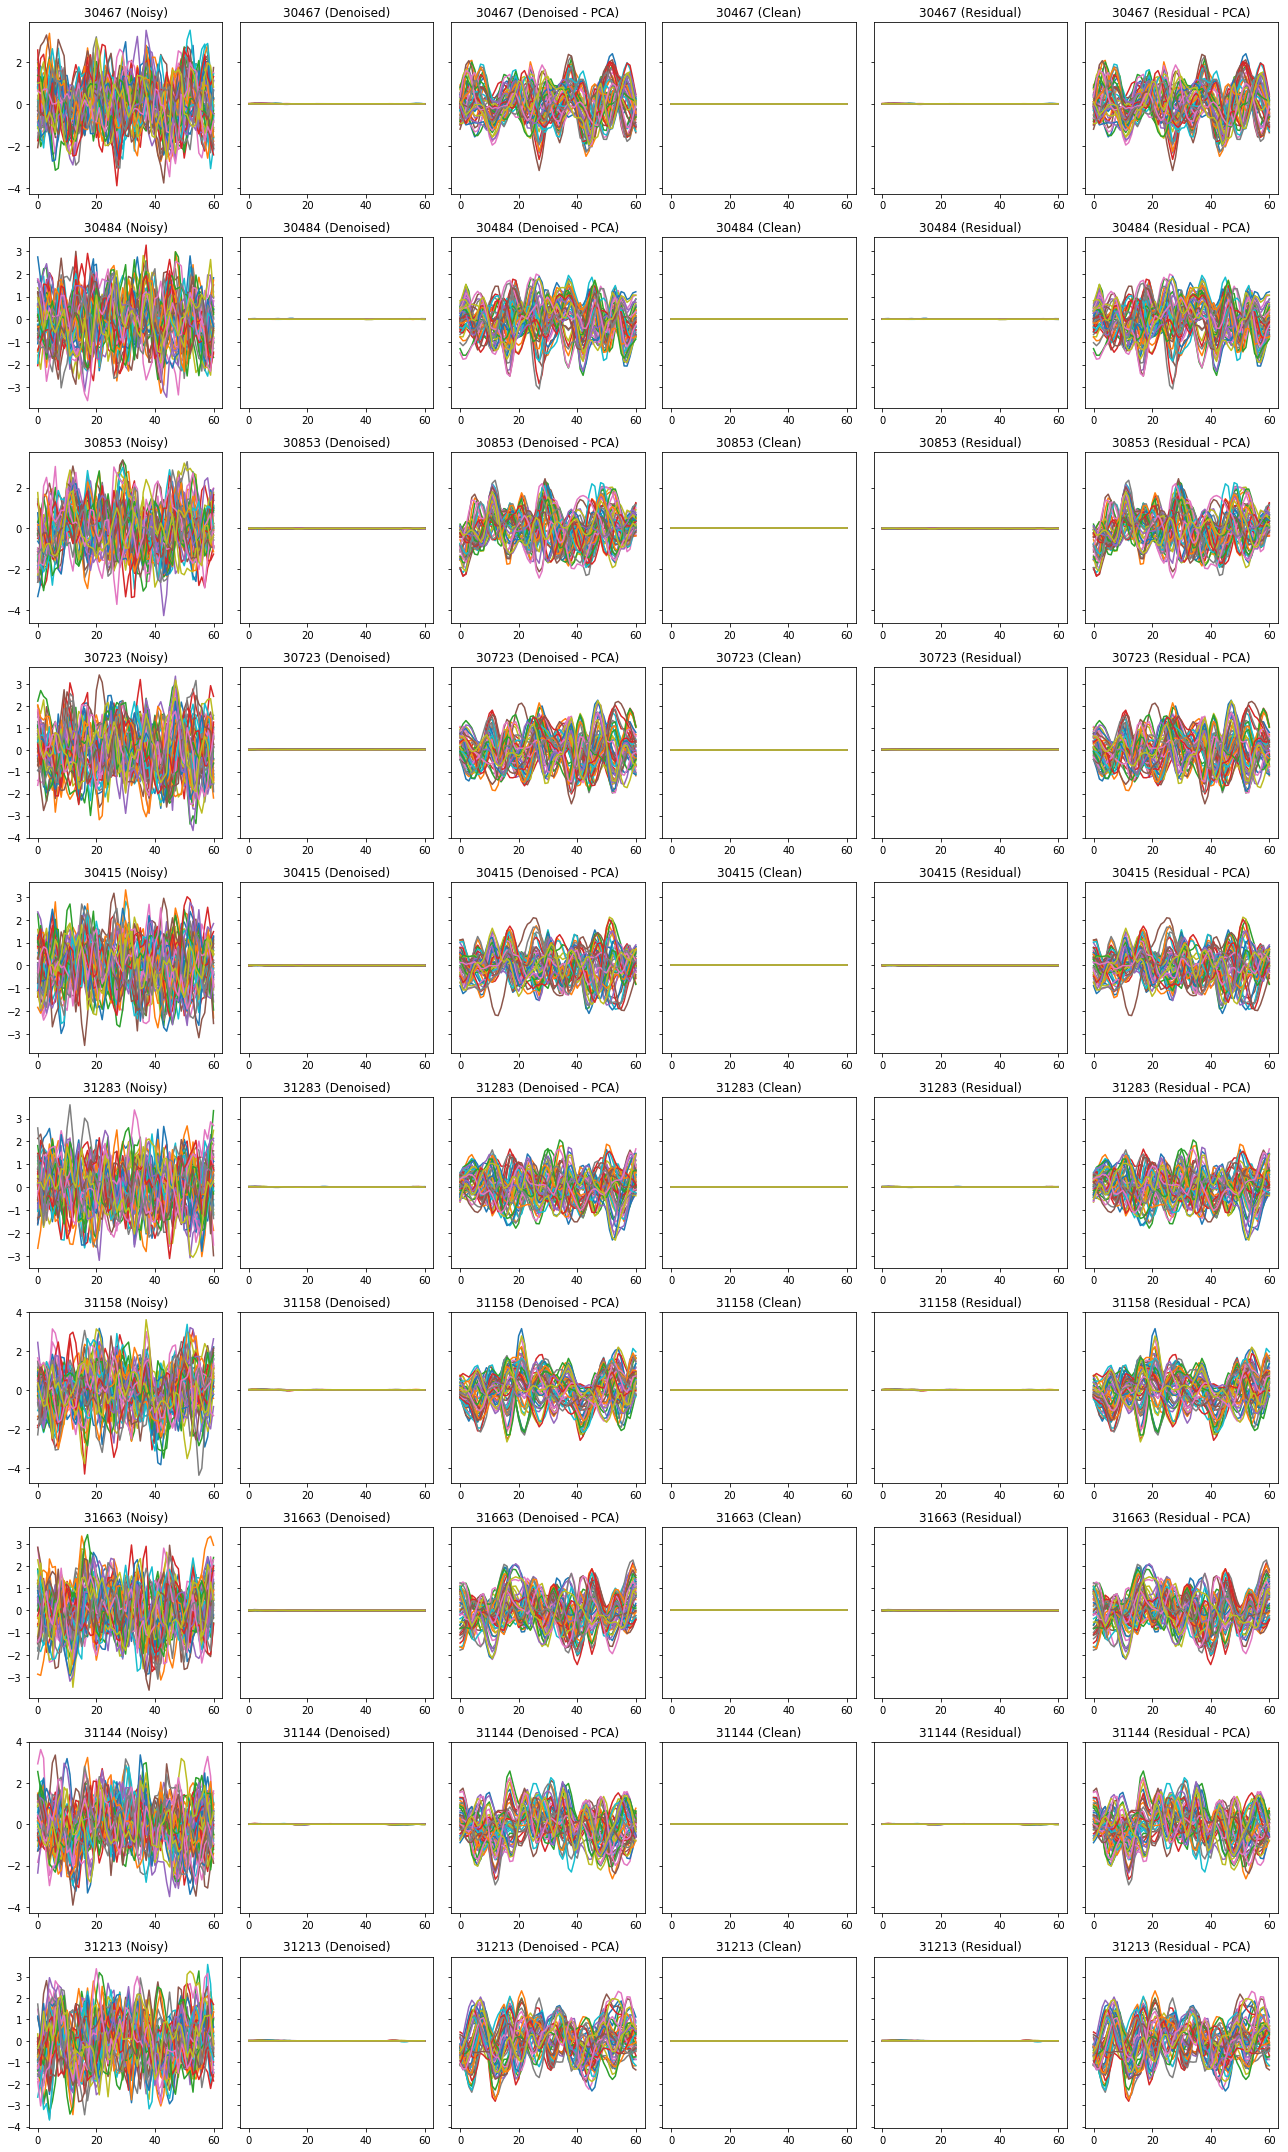

In [34]:
plot.grid_from_array([np.squeeze(x_test_noisy),
                      x_test_denoised,
                      x_test_denoised_pca,
                      np.squeeze(x_test_clean),
                      residual,
                      residual_pca],
                     axis=0,
                     group_names=('Noisy', 'Denoised', 'Denoised - PCA', 'Clean', 'Residual', 'Residual - PCA'),
                     elements=errors_sorted_idx[:10],
                     auto_figsize=3,
                     sharey='row')

In [61]:
def plot_from_indexes(dataset, model, idxs):
    sub_noisy = np.stack(test_set.df_noisy[idxs].waveform.values)
    sub_clean = np.stack(test_set.df_clean[idxs].waveform.values)
    sbu_denoised = predict(model, sub_clean)

    plot.grid_from_array([sub_noisy,
                          sbu_denoised,
                          sub_clean],
                         axis=0,
                         group_names=('Noisy', 'Denoised', 'Clean'),
                         elements=5,
                         figsize=(10, 10),
                         sharey='row')

In [62]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'zero')

NameError: name 'test_set' is not defined

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'collided')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'temporally misaligned')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'spatially misaligned')

In [ ]:
plot_from_indexes(test_set, autoencoder,
                  test_set.df_noisy.kind == 'from templates')

## Denoising (real) patches

## Denoising recordings

In [124]:
exp = RecordingExplorer(path_to_standarized)

In [192]:
patch_size = 61
n_patches = 5
offset = 150000

In [193]:
idxs = [(n * patch_size + offset, (n + 1) * patch_size + offset) for n in range(n_patches)]

In [194]:
patches = np.empty((n_patches, patch_size, 49, 1))

for i, (from_, to_) in enumerate(idxs):
    patches[i, :, :, 0] = exp.reader[from_:to_, :]

In [195]:
patches_denoised = np.squeeze(autoencoder.predict(patches))

In [196]:
patches_denoised = patches_denoised.reshape(-1, 49)

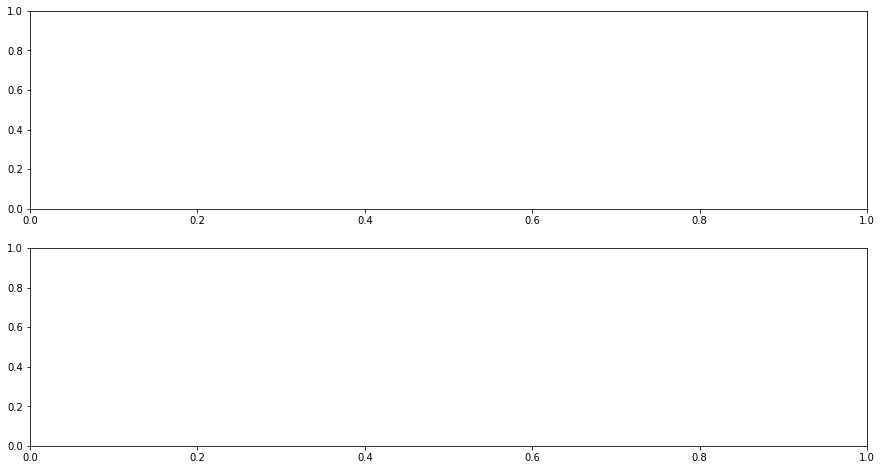

In [197]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

In [198]:
_ = ax1.plot(patches_denoised)
_ = ax2.plot(exp.reader[idxs[0][0]:idxs[-1][1]])

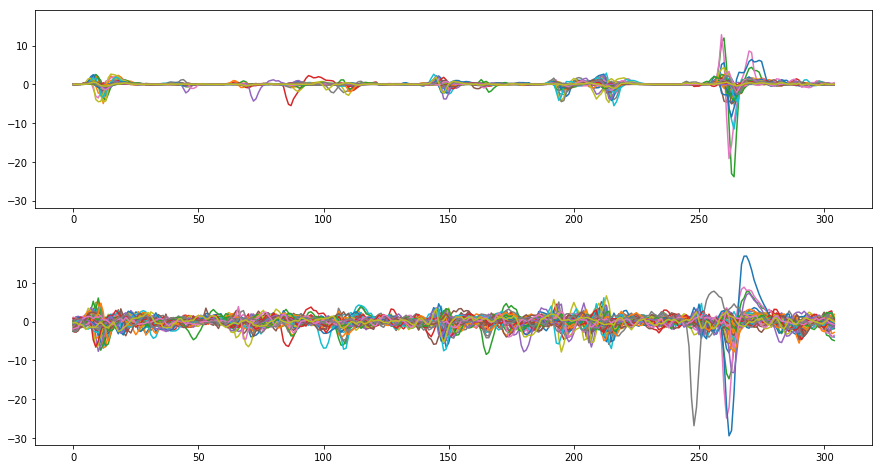

In [199]:
fig